## Statistical analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import functions as fun

from scipy import stats
import scipy.stats as st
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal

%matplotlib inline

In [2]:
df_demo = pd.read_csv("../data/for_tableau/df_demo.csv")
df_exp = pd.read_csv("../data/for_tableau/df_experiment_tot.csv")
df_final = pd.read_csv("../data/for_tableau/df_final.csv")

In [3]:
df_final["Variation"] = df_final["Variation"].map(fun.replace_nan)
df_final_included = df_final[ df_final["Variation"].isin(["Test", "Control"])]

In [4]:
df_exp_final = pd.merge(df_final_included, df_exp, on = "client_id", how = "inner") 

In [5]:
df_test = df_exp_final[df_exp_final["Variation"] == "Test"]
df_control = df_exp_final[df_exp_final["Variation"] == "Control"]

## Completion rate

Null hypothesis --> there is no difference in the completion rate between the old version of the website and the new web design (**rejected**).

**Results** = the completion rate of clients who were exposed to the new web design is significantly higher than the ones exposed to the old version (p-value < 0.0001). In this case, the data from both groups did not follow a normal distribution, so the statistical test performed was a Mann-Whitney U test (the test ranks all values from low to high and compares the mean of the ranks).

In [6]:
average_ctrl,_ = fun.completion_rate(df_control)
average_test,_ = fun.completion_rate(df_test)

print(f"""The average completion rate for the control group is: {average_ctrl}%
The average completion rate for the test group is: {average_test}%""")

The average completion rate for the control group is: 17.66%
The average completion rate for the test group is: 20.6%


In [7]:
_,completion_rate_ctrl = fun.completion_rate(df_control)
_,completion_rate_test = fun.completion_rate(df_test)

### Check for normality 

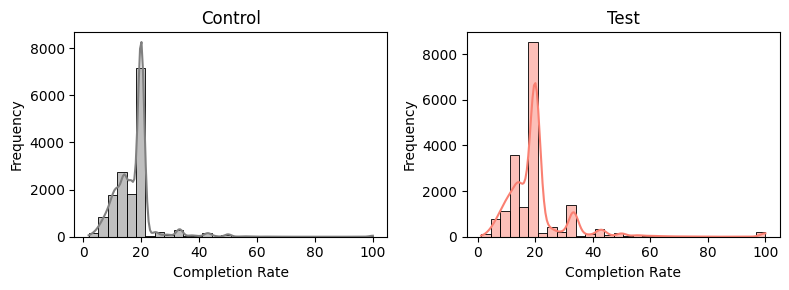

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

sns.histplot(completion_rate_ctrl, bins=30, kde=True, color="grey", alpha=0.5, ax = ax1)
ax1.set_title("Control")
ax1.set_xlabel("Completion Rate")
ax1.set_ylabel("Frequency")


sns.histplot(completion_rate_test, bins=30, kde=True, color="salmon", alpha=0.5, ax = ax2)
ax2.set_title("Test")
ax2.set_xlabel("Completion Rate")
ax2.set_ylabel("Frequency")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


- Kolmogorov-Smirnov Test to check if data follow a **normal distribution**

In [9]:
# CONTROL

standardized_rate_ctrl = (completion_rate_ctrl - completion_rate_ctrl.mean()) / completion_rate_ctrl.std(ddof=1)
ks_test_statistic, ks_p_value = stats.kstest(standardized_rate_ctrl, 'norm')

ks_test_statistic, ks_p_value

(0.3173879705047148, 0.0)

In [10]:
# TEST

standardized_rate_test = (completion_rate_test - completion_rate_test.mean()) / completion_rate_test.std(ddof=1)
ks_test_statistic, ks_p_value = stats.kstest(standardized_rate_test, 'norm')

ks_test_statistic, ks_p_value

(0.34276045404099575, 0.0)

(0.24318221004907714, 0.0)

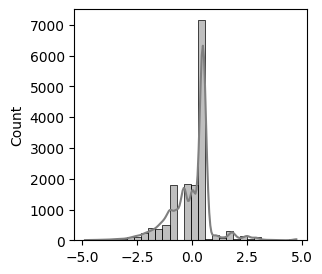

In [11]:
log_transformed_rate_ctrl = np.log1p(completion_rate_ctrl) 
standardized_log_rate_ctrl = (log_transformed_rate_ctrl - log_transformed_rate_ctrl.mean()) / log_transformed_rate_ctrl.std(ddof=1)


plt.figure(figsize=(3,3))
sns.histplot(standardized_log_rate_ctrl, kde=True, bins=30, color="grey")

ks_test_statistic, ks_p_value = stats.kstest(standardized_log_rate_ctrl, 'norm')

ks_test_statistic, ks_p_value

<Axes: ylabel='Count'>

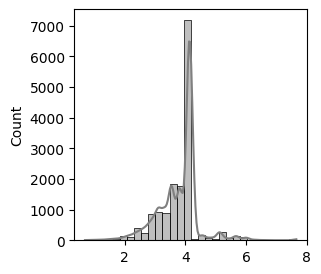

In [12]:
rate_ctrl_boxcox, _ = st.boxcox(completion_rate_ctrl)
plt.figure(figsize=(3,3))
sns.histplot(rate_ctrl_boxcox, kde=True, bins=30, color="grey")

**Data from completion rate do not follow a normal distribution (even after transforming them), therefore I will compare them with Mann-Whitney U test, non-parametric test equal to the t-test for two samples**

In [13]:
statistic, p_value = mannwhitneyu(completion_rate_ctrl.values, completion_rate_test.values)
print(f"""statistic: {statistic: .3f}, 
p_value: {p_value}""")

statistic:  123217741.500, 
p_value: 1.9205656300064737e-131


In [14]:
rate_df = pd.concat([completion_rate_ctrl.rename("Control"), completion_rate_test.rename("Test")], axis=1)

rate_df_melted = rate_df.melt(var_name="Group", value_name="Completion Rate", ignore_index=False).dropna().reset_index()

rate_df_melted.to_csv("../data/for_tableau/Compl_rate_ctrl_test.csv", index=False)
rate_df_melted.shape

(34121, 3)

In [15]:
rate_df_melted.head()

,client_id,Group,Completion Rate
0,1195,Control,20.0
1,1197,Control,14.3
2,3743,Control,20.0
3,5354,Control,14.3
4,6642,Control,20.0


(0.0, 40.0)

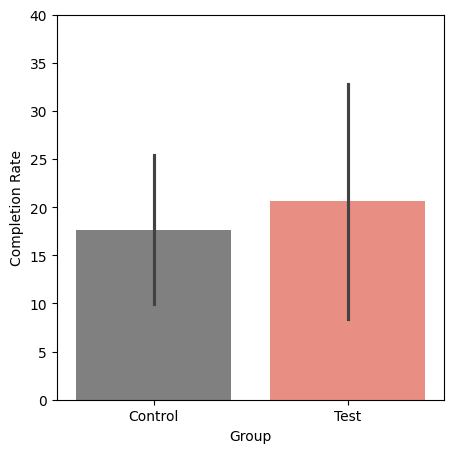

In [16]:
plt.figure(figsize=(5,5))
sns.barplot(data = rate_df_melted, x="Group", y="Completion Rate", hue = "Group", errorbar="sd", 
            palette = {"Control":"grey", "Test":"salmon"})
plt.ylim(0,40)

In [17]:
df_demo["age_category"] = df_demo["clnt_age"].map(fun.categ_age)
df_demo.to_csv("../data/for_tableau/df_demo_age_cat.csv", index=False)

## Average duration users spend on each step

Null hypothesis: there is no difference in the average time clients spend on each step of the process between the old version of the website and the new web design.

1) Is the mean total process time for all the clients significanlty different between the control and test group?
2) Is the mean spent in each step the same among all steps? Is there a difference between control and test group?

**Results**

Data on average time spent to complete the whole process and data from each step are not-normally distributed, so the statistical test perfromed are non-parametric Mann-Whitney U test (equivalent to t-test) to compare two samples, and Fridman test (equivalent to one-way ANOVA) with posthoc Tuckey's test for multiple comparisons of time spent between the 4 steps.

- The mean total process time for all the clients is significantly different between control and test clients groups.

- The time spent in each step is significantly different, both in control and in test groups.

In [18]:
average_ctrl, tot_ctrl, df_time_ctrl = fun.time_steps(df_control)

C:\Users\laura\Documents\IronHack\Module_2\Project_2\notebooks\functions.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date_time"] = pd.to_datetime(df["date_time"])


The average activity duration of clients for each step is:
    Between Start and Step_1:  25.62 seconds
    Between Step_1 and Step_2:  31.77 seconds
    Between Step_2 and Step_3:  74.61 seconds
    Between Step_3 and Confirm:  90.29 seconds
    
    The total average duration to complete the process is:  55.57 seconds


In [19]:
df_time_ctrl.head()

,Start-Step1,Step1-Step2,Step2-Step3,Step3-Confirm
client_id,,,,
1195,33.0,98.0,31.0,83.0
1197,4.0,68.0,6.0,17.0
3743,13.0,39.0,141.0,99.0
6977,30.0,5.0,64.0,128.0
6985,35.0,46.0,51.0,199.0


In [20]:
average_test, tot_test, df_time_test = fun.time_steps(df_test)

C:\Users\laura\Documents\IronHack\Module_2\Project_2\notebooks\functions.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date_time"] = pd.to_datetime(df["date_time"])


The average activity duration of clients for each step is:
    Between Start and Step_1:  19.84 seconds
    Between Step_1 and Step_2:  27.50 seconds
    Between Step_2 and Step_3:  72.67 seconds
    Between Step_3 and Confirm:  78.09 seconds
    
    The total average duration to complete the process is:  49.53 seconds


In [21]:
df_time_ctrl["total_time"] = df_time_ctrl[["Start-Step1", "Step1-Step2", "Step2-Step3", "Step3-Confirm"]].mean(axis=1)
df_time_test["total_time"] = df_time_test[["Start-Step1", "Step1-Step2", "Step2-Step3", "Step3-Confirm"]].mean(axis=1)

In [22]:
time_step_df = pd.concat([df_time_ctrl, df_time_test], keys = ["Control", "Test"])
time_step_df.reset_index(inplace=True)
time_step_df

,level_0,client_id,Start-Step1,Step1-Step2,Step2-Step3,Step3-Confirm,total_time
0,Control,1195,33.0,98.0,31.0,83.0,61.25
1,Control,1197,4.0,68.0,6.0,17.0,23.75
2,Control,3743,13.0,39.0,141.0,99.0,73.00
3,Control,6977,30.0,5.0,64.0,128.0,56.75
4,Control,6985,35.0,46.0,51.0,199.0,82.75
...,...,...,...,...,...,...,...
20796,Test,9998773,11.0,23.0,125.0,136.0,73.75
20797,Test,9998851,7.0,26.0,101.0,31.0,41.25
20798,Test,9998964,55.0,16.0,107.0,74.0,63.00
20799,Test,9999009,8.0,26.0,19.0,118.0,42.75


In [23]:
melted_time_df = time_step_df.melt(id_vars=["client_id", "level_0"], value_vars=["Start-Step1", "Step1-Step2", "Step2-Step3", "Step3-Confirm", "total_time"], 
                                   var_name="Step", value_name="Time")

melted_time_df.rename(columns = {"level_0":"Group"}, inplace=True)

melted_time_df.to_csv("../data/for_tableau/Time_steps_ctrl_test.csv", index=False)
melted_time_df

,client_id,Group,Step,Time
0,1195,Control,Start-Step1,33.00
1,1197,Control,Start-Step1,4.00
2,3743,Control,Start-Step1,13.00
3,6977,Control,Start-Step1,30.00
4,6985,Control,Start-Step1,35.00
...,...,...,...,...
104000,9998773,Test,total_time,73.75
104001,9998851,Test,total_time,41.25
104002,9998964,Test,total_time,63.00
104003,9999009,Test,total_time,42.75


### 1. Is the mean total process time for all the clients significanlty different between the control and test group?

Yes, Mann-Whitney U test showed a p-value < 0.001, so the mean total process time between control and test group is significantly different. 

### Check for normality 

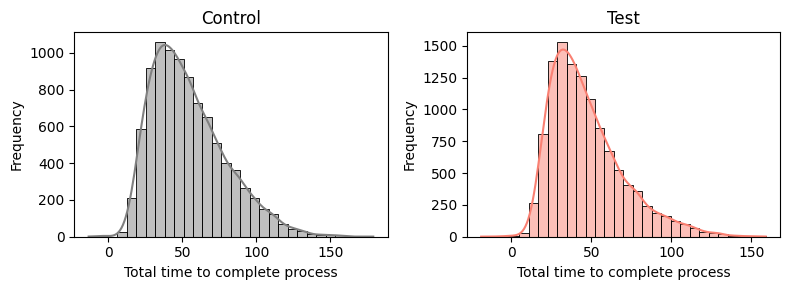

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

sns.histplot(df_time_ctrl["total_time"], bins=30, kde=True, color="grey", alpha=0.5, ax = ax1)
ax1.set_title("Control")
ax1.set_xlabel("Total time to complete process")
ax1.set_ylabel("Frequency")


sns.histplot(df_time_test["total_time"], bins=30, kde=True, color="salmon", alpha=0.5, ax = ax2)
ax2.set_title("Test")
ax2.set_xlabel("Total time to complete process")
ax2.set_ylabel("Frequency")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


Distribution measures:
    Skewness: 0.8433132558050889
    Kurtosis: 0.5603837400152747


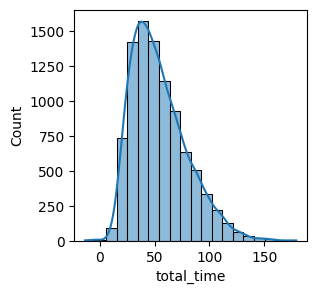

In [25]:
fun.histo_numerical(df_time_ctrl, "total_time")

In [26]:
# CONTROL

standardized_time_ctrl = (df_time_ctrl["total_time"] - df_time_ctrl["total_time"].mean()) / df_time_ctrl["total_time"].std(ddof=1)
ks_test_statistic, ks_p_value = stats.kstest(standardized_time_ctrl, 'norm')

ks_test_statistic, ks_p_value

(0.07690499224870329, 4.76298181612323e-48)

In [27]:
# TEST

standardized_time_test = (df_time_test["total_time"] - df_time_test["total_time"].mean()) / df_time_test["total_time"].std(ddof=1)
ks_test_statistic, ks_p_value = stats.kstest(standardized_time_test, 'norm')

ks_test_statistic, ks_p_value

(0.09193714410085324, 2.1951998413614992e-85)

C:\Users\laura\Documents\IronHack\Module_2\Project_2\project2_env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='total_time', ylabel='Count'>

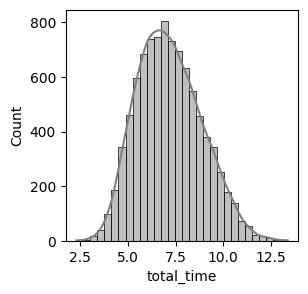

In [28]:
time_ctrl_sqrt = np.sqrt(df_time_ctrl["total_time"])
plt.figure(figsize=(3,3))
sns.histplot(time_ctrl_sqrt, kde=True, bins=30, color="grey")

nan nan


<Axes: xlabel='total_time', ylabel='Count'>

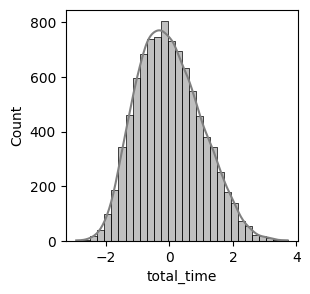

In [29]:
standardized_time_ctrl_sqrt = (time_ctrl_sqrt - time_ctrl_sqrt.mean()) / time_ctrl_sqrt.std(ddof=1)
ks_test_statistic, ks_p_value = stats.kstest(standardized_time_ctrl_sqrt, 'norm')

print(ks_test_statistic, ks_p_value)
plt.figure(figsize=(3,3))
sns.histplot(standardized_time_ctrl_sqrt, kde=True, bins=30, color="grey")

**Data from total time spent during the process do not follow a normal distribution (even after transforming them), therefore I will compare them with Mann-Whitney U test, non-parametric test equal to the t-test for two samples**

In [30]:
statistic, p_value = mannwhitneyu(df_time_ctrl["total_time"], df_time_test["total_time"])
print(f"""statistic: {statistic: .3f}, 
p_value: {p_value}""")

statistic:  62815249.000, 
p_value: 1.8126576836066964e-105


(0.0, 100.0)

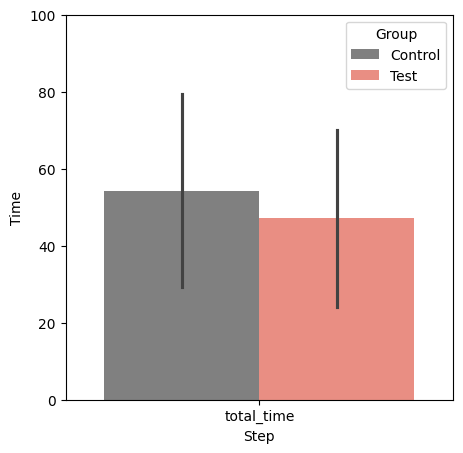

In [33]:
total_time_df = melted_time_df[ melted_time_df["Step"] == "total_time"]

plt.figure(figsize=(5,5))
sns.barplot(data = total_time_df, x="Step", y="Time", hue = "Group", errorbar="sd", 
            palette = {"Control":"grey", "Test":"salmon"})
plt.ylim(0,100)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Start-Step1'),
  Text(1, 0, 'Step1-Step2'),
  Text(2, 0, 'Step2-Step3'),
  Text(3, 0, 'Step3-Confirm'),
  Text(4, 0, 'total_time')])

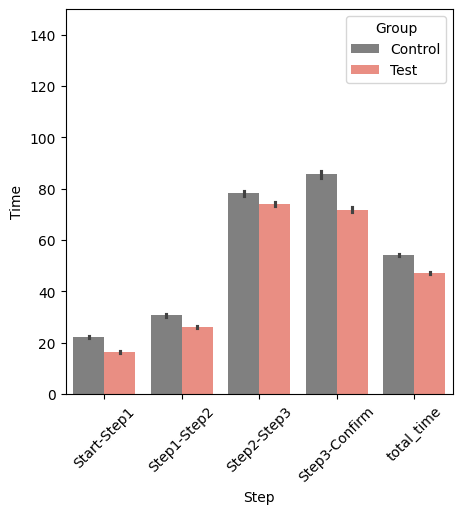

In [34]:
plt.figure(figsize=(5,5))
sns.barplot(data = melted_time_df, x="Step", y="Time", hue = "Group", errorbar="ci", 
            palette = {"Control":"grey", "Test":"salmon"})
plt.ylim(0,150)
plt.xticks(rotation=45)

### 2. Is the mean spent in each step the same among all steps? Is there a difference between control and test group?

### Check for normality 

Start-Step1 p_value: 1.3991391564412151e-246
Step1-Step2 p_value: 2.5587022202788726e-262
Step2-Step3 p_value: 1.4218985182333514e-62
Step3-Confirm p_value: 1.5116214976422025e-154


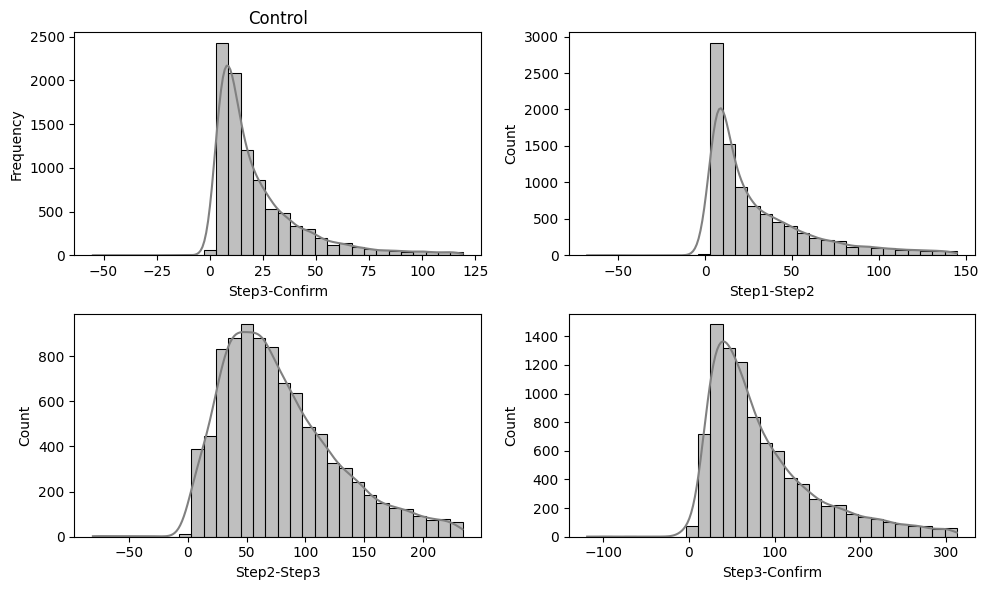

In [35]:
# CONTROL

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 6))

sns.histplot(df_time_ctrl["Start-Step1"], bins=30, kde=True, color="grey", alpha=0.5, ax = ax1)
ax1.set_title("Control")
ax1.set_xlabel("Start-Step1")
ax1.set_ylabel("Frequency")

standardized_start = (df_time_ctrl["Start-Step1"] - df_time_ctrl["Start-Step1"].mean()) / df_time_ctrl["Start-Step1"].std(ddof=1)
_, ks_p_value_start = stats.kstest(standardized_start, 'norm')

print(f"Start-Step1 p_value: {ks_p_value_start}")


sns.histplot(df_time_ctrl["Step1-Step2"], bins=30, kde=True, color="grey", alpha=0.5, ax = ax2)
ax1.set_title("Control")
ax1.set_xlabel("Step1-Step2")
ax1.set_ylabel("Frequency")

standardized_step2 = (df_time_ctrl["Step1-Step2"] - df_time_ctrl["Step1-Step2"].mean()) / df_time_ctrl["Step1-Step2"].std(ddof=1)
_, ks_p_value_step2 = stats.kstest(standardized_step2, 'norm')

print(f"Step1-Step2 p_value: {ks_p_value_step2}")


sns.histplot(df_time_ctrl["Step2-Step3"], bins=30, kde=True, color="grey", alpha=0.5, ax = ax3)
ax1.set_title("Control")
ax1.set_xlabel("Step2-Step3")
ax1.set_ylabel("Frequency")

standardized_step3 = (df_time_ctrl["Step2-Step3"] - df_time_ctrl["Step2-Step3"].mean()) / df_time_ctrl["Step2-Step3"].std(ddof=1)
_, ks_p_value_step3 = stats.kstest(standardized_step3, 'norm')

print(f"Step2-Step3 p_value: {ks_p_value_step3}")

sns.histplot(df_time_ctrl["Step3-Confirm"], bins=30, kde=True, color="grey", alpha=0.5, ax = ax4)
ax1.set_title("Control")
ax1.set_xlabel("Step3-Confirm")
ax1.set_ylabel("Frequency")

standardized_conf = (df_time_ctrl["Step3-Confirm"] - df_time_ctrl["Step3-Confirm"].mean()) / df_time_ctrl["Step3-Confirm"].std(ddof=1)
_, ks_p_value_conf = stats.kstest(standardized_conf, 'norm')

print(f"Step3-Confirm p_value: {ks_p_value_conf}")


# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Start-Step1 p_value: 0.0
Step1-Step2 p_value: 4.19680641970329e-182
Step2-Step3 p_value: 7.045516570475496e-82
Step3-Confirm p_value: 0.0


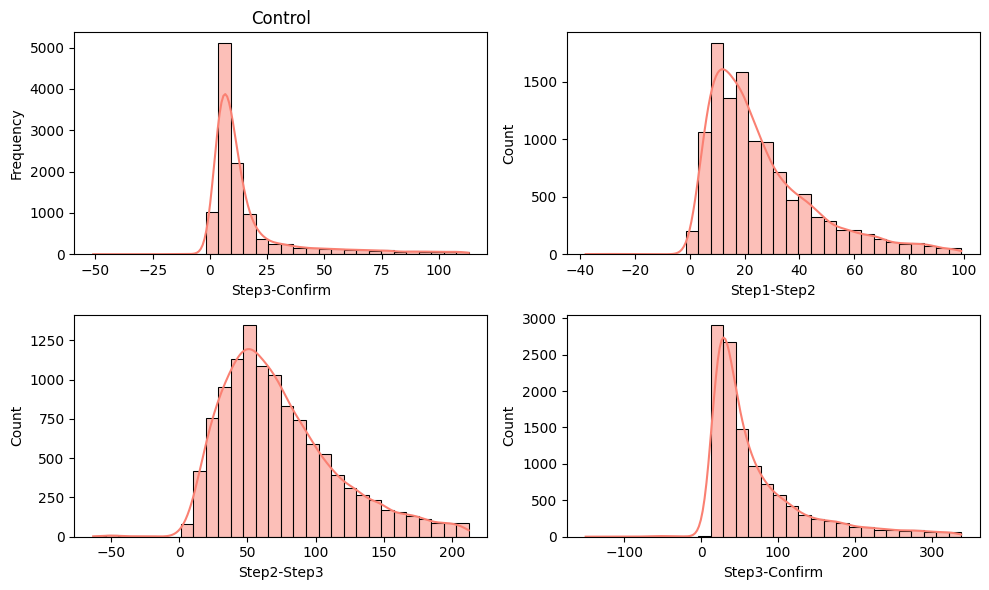

In [36]:
# TEST

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 6))

sns.histplot(df_time_test["Start-Step1"], bins=30, kde=True, color="salmon", alpha=0.5, ax = ax1)
ax1.set_title("Control")
ax1.set_xlabel("Start-Step1")
ax1.set_ylabel("Frequency")

standardized_start = (df_time_test["Start-Step1"] - df_time_test["Start-Step1"].mean()) / df_time_test["Start-Step1"].std(ddof=1)
_, ks_p_value_start = stats.kstest(standardized_start, 'norm')

print(f"Start-Step1 p_value: {ks_p_value_start}")


sns.histplot(df_time_test["Step1-Step2"], bins=30, kde=True, color="salmon", alpha=0.5, ax = ax2)
ax1.set_title("Control")
ax1.set_xlabel("Step1-Step2")
ax1.set_ylabel("Frequency")

standardized_step2 = (df_time_test["Step1-Step2"] - df_time_test["Step1-Step2"].mean()) / df_time_test["Step1-Step2"].std(ddof=1)
_, ks_p_value_step2 = stats.kstest(standardized_step2, 'norm')

print(f"Step1-Step2 p_value: {ks_p_value_step2}")


sns.histplot(df_time_test["Step2-Step3"], bins=30, kde=True, color="salmon", alpha=0.5, ax = ax3)
ax1.set_title("Control")
ax1.set_xlabel("Step2-Step3")
ax1.set_ylabel("Frequency")

standardized_step3 = (df_time_test["Step2-Step3"] - df_time_test["Step2-Step3"].mean()) / df_time_test["Step2-Step3"].std(ddof=1)
_, ks_p_value_step3 = stats.kstest(standardized_step3, 'norm')

print(f"Step2-Step3 p_value: {ks_p_value_step3}")

sns.histplot(df_time_test["Step3-Confirm"], bins=30, kde=True, color="salmon", alpha=0.5, ax = ax4)
ax1.set_title("Control")
ax1.set_xlabel("Step3-Confirm")
ax1.set_ylabel("Frequency")

standardized_conf = (df_time_test["Step3-Confirm"] - df_time_test["Step3-Confirm"].mean()) / df_time_test["Step3-Confirm"].std(ddof=1)
_, ks_p_value_conf = stats.kstest(standardized_conf, 'norm')

print(f"Step3-Confirm p_value: {ks_p_value_conf}")


# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

**Data transformation testing**

(0.911719615963227, 0.0)

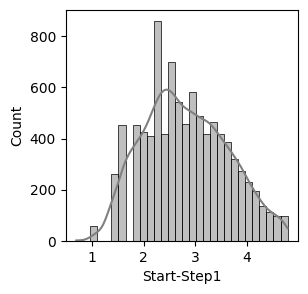

In [38]:
time_ctrl_start_log = np.log1p(df_time_ctrl["Start-Step1"])
plt.figure(figsize=(3,3))
sns.histplot(time_ctrl_start_log, kde=True, bins=30, color="grey")

time_ctrl_start_log.dropna(inplace=True)
standardized_start_log = (time_ctrl_start_log - time_ctrl_start_log.mean()) / time_ctrl_start_log.std(ddof=1)
ks_statistic, ks_p_value_start = stats.kstest(time_ctrl_start_log, 'norm')
ks_statistic, ks_p_value_start

(0.9846490738491651, 0.0)

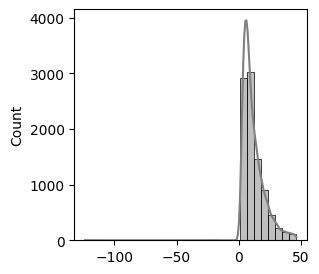

In [39]:
time_ctrl_start_yeojohnson,_ = stats.yeojohnson(df_time_ctrl["Start-Step1"])
plt.figure(figsize=(3,3))
sns.histplot(time_ctrl_start_yeojohnson, kde=True, bins=30, color="grey")

standardized_start_yeojohnson = (time_ctrl_start_yeojohnson - time_ctrl_start_yeojohnson.mean()) / time_ctrl_start_yeojohnson.std(ddof=1)
ks_statistic, ks_p_value_start = stats.kstest(time_ctrl_start_yeojohnson, 'norm')
ks_statistic, ks_p_value_start

C:\Users\laura\Documents\IronHack\Module_2\Project_2\project2_env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


(0.9519831512559318, 0.0)

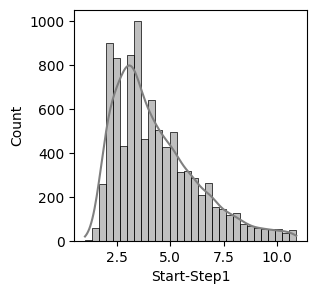

In [40]:
time_ctrl_start_sqrt = np.sqrt(df_time_ctrl["Start-Step1"])
plt.figure(figsize=(3,3))
sns.histplot(time_ctrl_start_sqrt, kde=True, bins=30, color="grey")

time_ctrl_start_sqrt.dropna(inplace=True)
standardized_start_log = (time_ctrl_start_sqrt - time_ctrl_start_sqrt.mean()) / time_ctrl_start_sqrt.std(ddof=1)
ks_statistic, ks_p_value_start = stats.kstest(time_ctrl_start_sqrt, 'norm')
ks_statistic, ks_p_value_start

**Data from time spent during each step do not follow a normal distribution (even after transformation)**, therefore I will compare them with non-parametric tests. 

1) Since I want to compare the time spent in each step and between the two groups, I will apply Friedman test test (equivalent to one-way ANOVA for *repeated measurments*).

**Friedman test for multiple comparisons (non-parametric)**

In [42]:
# Control
ft_statistic, ft_p_value = st.friedmanchisquare(df_time_ctrl["Start-Step1"], df_time_ctrl["Step1-Step2"], 
                                                df_time_ctrl["Step2-Step3"], df_time_ctrl["Step3-Confirm"])

print(f"""CONTROL group:
Friedman test statistic: {ft_statistic}
Friedman test p-value: {ft_p_value}""")

# Test

ft_statistic_test, ft_p_value_test = st.friedmanchisquare(df_time_test["Start-Step1"], df_time_test["Step1-Step2"], 
                                                df_time_test["Step2-Step3"], df_time_test["Step3-Confirm"])

print(f"""TEST group:
Friedman test statistic: {ft_statistic_test}
Friedman test p-value: {ft_p_value_test}""")

CONTROL group:
Friedman test statistic: 13661.423236153827
Friedman test p-value: 0.0
TEST group:
Friedman test statistic: 19475.915699242905
Friedman test p-value: 0.0


- Friedman test shows that there is a significant difference between the time spent in the different steps, both for control and for test group. 

- Now to assess which of the steps are significantly different, I perform the *post hoc* **Tuckey's test for multiple comparisons** (pairwise).

  The null hypothesis of this test is that the distributions underlying the samples all have the same mean

In [43]:
t_results = st.tukey_hsd(df_time_ctrl["Start-Step1"], df_time_ctrl["Step1-Step2"], 
                         df_time_ctrl["Step2-Step3"], df_time_ctrl["Step3-Confirm"])


print(f"""CONTROL group:
{t_results}""")

# Test

t_results_test = st.tukey_hsd(df_time_test["Start-Step1"], df_time_test["Step1-Step2"], 
                               df_time_test["Step2-Step3"], df_time_test["Step3-Confirm"])

print(f"""TEST group:
{t_results_test}""")


CONTROL group:
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -8.489     0.000   -10.157    -6.820
 (0 - 2)    -55.966     0.000   -57.634   -54.297
 (0 - 3)    -63.367     0.000   -65.036   -61.699
 (1 - 0)      8.489     0.000     6.820    10.157
 (1 - 2)    -47.477     0.000   -49.145   -45.808
 (1 - 3)    -54.879     0.000   -56.547   -53.210
 (2 - 0)     55.966     0.000    54.297    57.634
 (2 - 1)     47.477     0.000    45.808    49.145
 (2 - 3)     -7.402     0.000    -9.070    -5.733
 (3 - 0)     63.367     0.000    61.699    65.036
 (3 - 1)     54.879     0.000    53.210    56.547
 (3 - 2)      7.402     0.000     5.733     9.070

TEST group:
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -9.683     0.000   -11.087    -8.279
 (0 - 2)    -57.427     0.000   -58.831   -56.023
 (0 - 3)    -55.432     0.000   -56.

## Error rate

Null hypothesis: there is no difference in the rate of errors that clients did during the process between the old version of the website and the new web design.

**Results**

In [44]:
# Overall average time calculated as total number of errors divided by the total number of observations, 
# and then multiplying by 100 to convert it to a percentage.
# This method calculates the error rate based on the frequency of errors over all observations.

tot_errors_ctrl = fun.sequence_total_errors(df_control)
tot_errors_test = fun.sequence_total_errors(df_test)

The overall error rate for the dataset is:  13.59%
The overall error rate for the dataset is:  15.13%


In [45]:
df_errors_ctrl = fun.sequence_individual_errors(df_control)
df_errors_test = fun.sequence_individual_errors(df_test)

In [46]:
df_errors_ctrl.head()

,Error Rate (%)
client_id,
1028,33.333333
1104,50.000000
1186,25.000000
1195,0.000000
1197,14.285714


In [47]:
# In this case the mean is different from the overall rate because it is considering the individual error rates for each observation

fun.centrality_dispersion(df_errors_ctrl, "Error Rate (%)")

Measures of centrality and dispersion for Error Rate (%):
    Mean: 11.42
    Median: 0.0
    Mode: 0.0
    Variance: 204.63
    Standard deviation: 14.31


In [48]:
fun.centrality_dispersion(df_errors_test, "Error Rate (%)")

Measures of centrality and dispersion for Error Rate (%):
    Mean: 12.41
    Median: 10.0
    Mode: 0.0
    Variance: 227.18
    Standard deviation: 15.07


### Check for normality

Errors control p_value: 0.0
Errors test p_value: 0.0


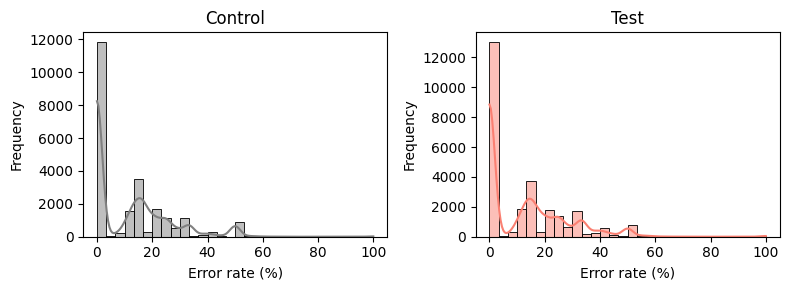

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

sns.histplot(df_errors_ctrl["Error Rate (%)"], bins=30, kde=True, color="grey", alpha=0.5, ax = ax1)
ax1.set_title("Control")
ax1.set_xlabel("Error rate (%)")
ax1.set_ylabel("Frequency")

standardized_error_ctrl = (df_errors_ctrl["Error Rate (%)"] - df_errors_ctrl["Error Rate (%)"].mean()) / df_errors_ctrl["Error Rate (%)"].std(ddof=1)
_, ks_p_value_error_ctrl = stats.kstest(standardized_error_ctrl, 'norm')

print(f"Errors control p_value: {ks_p_value_error_ctrl}")

sns.histplot(df_errors_test["Error Rate (%)"], bins=30, kde=True, color="salmon", alpha=0.5, ax = ax2)
ax2.set_title("Test")
ax2.set_xlabel("Error rate (%)")
ax2.set_ylabel("Frequency")

standardized_error_test = (df_errors_test["Error Rate (%)"] - df_errors_test["Error Rate (%)"].mean()) / df_errors_test["Error Rate (%)"].std(ddof=1)
_, ks_p_value_error_test = stats.kstest(standardized_error_test, 'norm')

print(f"Errors test p_value: {ks_p_value_error_test}")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

- There are a lot of zero value in these data so a better solution instead of trying to transform the data, is to directly use non-parametric test (Mann-Whitney U test in this case)

In [13]:
statistic, p_value = mannwhitneyu(df_errors_ctrl["Error Rate (%)"], df_errors_test["Error Rate (%)"])
print(f"""statistic: {statistic: .3f}, 
p_value: {p_value}""")

statistic:  307349616.000, 
p_value: 8.308180025774254e-11


In [50]:
error_df = pd.concat([df_errors_ctrl, df_errors_test], keys = ["Control", "Test"])
error_df.reset_index(inplace=True)
error_df.rename(columns = {"level_0":"Group"}, inplace=True)

error_df.to_csv("../data/for_tableau/Error_rates_ctrl_test.csv", index=False)